## [1] Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10<br>

Attribute Information:<br>

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Objective:

Compute T-sne plot for T-fid


## [1.1] Loading the data:

The dataset is available in two forms

1) .csv file<br>
2) SQLite Database
In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\hp\Downloads\amazon-fine-food-reviews\database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.isnull().values.any())

False


In [3]:
print(filtered_data['Score'].value_counts(normalize=True))

positive    0.843981
negative    0.156019
Name: Score, dtype: float64


In [4]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
filtered_data[['Summary','Score','Text']].head()

,Summary,Score,Text
0,Good Quality Dog Food,positive,I have bought several of the Vitality canned d...
1,Not as Advertised,negative,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",positive,This is a confection that has been around a fe...
3,Cough Medicine,negative,If you are looking for the secret ingredient i...
4,Great taffy,positive,Great taffy at a great price. There was a wid...


## Observation:

1)  No null value in dataset<br>

2) Approx 84 percentage of review is positive 

## [1.2] Data Cleaning: Deduplication

Let check whether there are dupicate entry or not,it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.


In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


## Observations:

1)  Same User(Geetha Krishnan) has multiple reviews ofwith the same values for HelpfulnessNumerator, HelpfulnessDenominator,  Score, Time, Summary and Text<br>
2)  It is inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it is decided to eliminate the rows having same parameters.<br>
3) The method used for the removing the redundancy is to first sort the data according to ProductId and then just keep the first similar product review and delelte the others.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

## Observation:

1)  There was 31 percetage of data which was duplicate

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [12]:
print(final.shape)
final['Score'].value_counts(normalize=True)

(364171, 10)


positive    0.843178
negative    0.156822
Name: Score, dtype: float64

## Observation:

1) The two rows had the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calculations



## [1.3] Text Preprocessing: Stemming, stop-word removal and Lemmatization.

We have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.<br>

Hence in the Preprocessing phase we do the following in the order below:-<br>

1. Begin by removing the html tags<br>
2. Remove any punctuations or limited set of special characters like , or . or # etc.<br>
3. Check if the word is made up of english letters and is not alpha-numeric<br>
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)<br>
5. Convert the word to lowercase<br>
6. Remove Stopwords<br>
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>
After which we collect the words used to describe positive and negative reviews

In [13]:
final=final[0:2000] #Sampling 2000 datapoints for preprocessing

In [14]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)


{'d', 'once', 'after', "you're", "mustn't", "wasn't", "wouldn't", "you'd", 'that', 'hasn', 'mightn', 'now', 'yourselves', 'o', 'who', 'hadn', "you've", 'if', 'own', "didn't", 'again', 'be', 'me', 'above', 'about', "mightn't", 'don', 'on', 'more', 'aren', 'your', 'itself', 'them', 'because', 'myself', 'no', 'will', 'doesn', 'ourselves', 'there', 'so', 'our', 'her', 'won', 'those', 'why', 'it', 'ma', 'an', 'between', "doesn't", 'for', 'to', "aren't", 'where', 'haven', 'll', "couldn't", 'during', 'its', 'such', 'each', 'has', 'mustn', 'does', 'than', 'his', 'm', 'are', 'having', 'most', 'is', 'then', 'they', 're', 'not', 'the', 'until', 'wasn', 'isn', 'over', 'under', "needn't", 'into', 'all', "haven't", 'when', 'yours', 'he', 'other', 'some', "hasn't", "you'll", 'below', 'further', 'here', 'theirs', 'can', 'but', 'with', 'shan', 'hers', 'same', 'too', 'we', 'what', 'doing', 'a', 'or', 'down', 'very', 'do', "that'll", 'have', 'ours', 'being', 've', 'couldn', 'how', 'from', 'just', 'while'

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

## Observation

1)  All The Stopwords From our review text has been removed<br>

2) All the sentence containg HTML tag has been removed

## [1.4]  TF-IDF

In [22]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)


In [23]:
final_tf_idf.get_shape()

(2000, 98992)

In [24]:
features = tf_idf_vect.get_feature_names()
len(features)


98992

In [25]:
type(final_tf_idf)

scipy.sparse.csr.csr_matrix

In [26]:
from scipy.sparse import csr_matrix
A = csr_matrix(final_tf_idf)
B=A.todense()
print(B.shape)

(2000, 98992)


In [27]:
l = final['Score']


## Observation:

1)  TfidVectorizer is returning a sparse matrix <br>
2) Dimesnsion Of matrix is 2000*98992

## T-SNE Plot

In [28]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(B)
print(standardized_data.shape)

(2000, 98992)


In [29]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state=0, perplexity=10,  n_iter=1000)
tsne_data = model.fit_transform(B)
tsne_data = np.vstack((tsne_data.T, l)).T

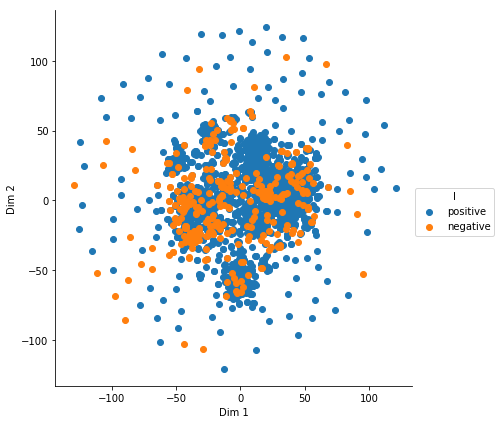

In [30]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim 1", "Dim 2", "l"))
sns.FacetGrid(tsne_df,hue="l",size=6).map(plt.scatter,'Dim 1','Dim 2').add_legend()
plt.show()


In [31]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state=0, perplexity=25,  n_iter=2000)
tsne_data = model.fit_transform(B)
tsne_data = np.vstack((tsne_data.T, l)).T

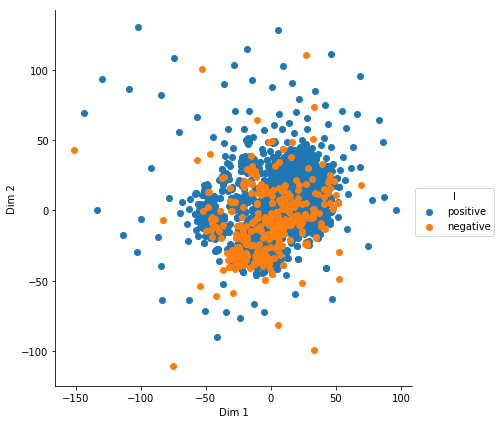

In [32]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim 1", "Dim 2", "l"))
sns.FacetGrid(tsne_df,hue="l",size=6).map(plt.scatter,'Dim 1','Dim 2').add_legend()
plt.show()


In [33]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state=0, perplexity=40,  n_iter=1000)
tsne_data = model.fit_transform(B)
tsne_data = np.vstack((tsne_data.T, l)).T

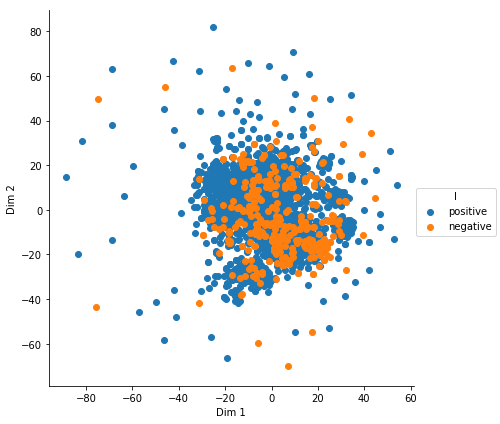

In [34]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim 1", "Dim 2", "l"))
sns.FacetGrid(tsne_df,hue="l",size=6).map(plt.scatter,'Dim 1','Dim 2').add_legend()
plt.show()


In [35]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state=0, perplexity=60,  n_iter=1000)
tsne_data = model.fit_transform(B)
tsne_data = np.vstack((tsne_data.T, l)).T

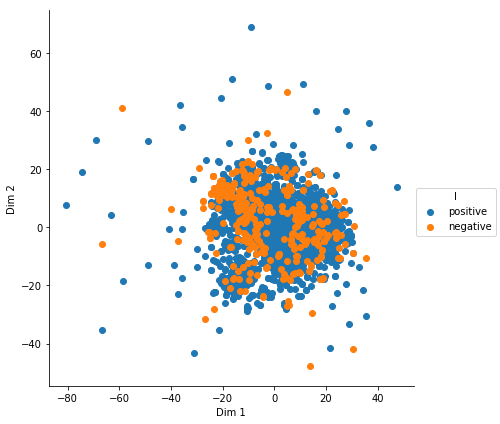

In [36]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim 1", "Dim 2", "l"))
sns.FacetGrid(tsne_df,hue="l",size=6).map(plt.scatter,'Dim 1','Dim 2').add_legend()
plt.show()


## Observation:
1) As We change our perplexity and iteration we are getting different plot<br>

2) We are not able to separate positive and negative review 